In [ ]:
import jax.numpy as jnp
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib import cm
import jax
from jax import grad, vmap
import tqdm
import itertools
import numpy as np
from scipy.linalg import eig
from mpl_toolkits.mplot3d import axes3d

In [ ]:
jax.config.update("jax_enable_x64", True)

In [ ]:
#Define 2D Gaussian kernel and derivatives
def kernel(s1,t1,s2,t2,sigma1,sigma2):
  K = jnp.exp(-((s1-t1)**2/(2*sigma1**2))-((s2-t2)**2/(2*sigma2**2)))
  #r = jnp.sqrt((s1-t1)**2/sigma1**2+(s2-t2)**2/sigma2**2)
  #K = (1+jnp.sqrt(5)*(r)+5/3*r**2)*jnp.exp(-jnp.sqrt(5)*r)
  #K = (s1*t1+s2*t2+sigma1)**sigma2
  return K

def kernel_dx1(s1,t1,s2,t2,sigma1,sigma2):
  #r = jnp.sqrt((s1-t1)**2/sigma1**2+(s2-t2)**2/sigma2**2)
  #K = jnp.exp(-jnp.sqrt(5)*r)*(-5/(3*sigma1**2)*(s1-t1)-5*jnp.sqrt(5)*(s1-t1)/(3*sigma1**2))
  return -(s1-t1)*kernel(s1,t1,s2,t2,sigma1,sigma2)/(sigma1**2)

def kernel_dy1(s1,t1,s2,t2,sigma1,sigma2):
  return -kernel_dx1(s1,t1,s2,t2,sigma1,sigma2)
  #-(t1-s1)*kernel(s1,t1,s2,t2,sigma1,sigma2)/(sigma1**2)

def kernel_dx2(s1,t1,s2,t2,sigma1,sigma2):
  #r = jnp.sqrt((s1-t1)**2/sigma1**2+(s2-t2)**2/sigma2**2)
  #K = jnp.exp(-jnp.sqrt(5)*r)*(-5/(3*sigma2**2)*(s2-t2)-5*jnp.sqrt(5)*(s2-t2)/(3*sigma2**2))
  return -(s2-t2)*kernel(s1,t1,s2,t2,sigma1,sigma2)/(sigma2**2)

def kernel_dy2(s1,t1,s2,t2,sigma1,sigma2):
  return -kernel_dx2(s1,t1,s2,t2,sigma1,sigma2)
  #-(t2-s2)*kernel(s1,t1,s2,t2,sigma1,sigma2)/(sigma2**2)

def kernel_dx1dy1(s1,t1,s2,t2,sigma1,sigma2):
  #r = jnp.sqrt((s1-t1)**2/sigma1**2+(s2-t2)**2/sigma2**2)
  #K = jnp.exp(-jnp.sqrt(5)*r)*(5/(3*sigma1**2)+5*jnp.sqrt(5)/(3*sigma1**2)*r-25/(3*sigma1**4)*(s1-t1)**2)
  return (sigma1**2-(s1-t1)**2)*kernel(s1,t1,s2,t2,sigma1,sigma2)/(sigma1**4)

def kernel_dx1dy2(s1,t1,s2,t2,sigma1,sigma2):
  #r = jnp.sqrt((s1-t1)**2/sigma1**2+(s2-t2)**2/sigma2**2)
  #K = jnp.exp(-jnp.sqrt(5)*r)*(-25*(s1-t1)*(s2-t2)/(3*sigma1**2*sigma2**2))
  return (t2-s2)*(s1-t1)*kernel(s1,t1,s2,t2,sigma1,sigma2)/(sigma1**2*sigma2**2)

def kernel_dx2dy1(s1,t1,s2,t2,sigma1,sigma2):
  return kernel_dx1dy2(s1,t1,s2,t2,sigma1,sigma2)
   #(s2-t2)*(t1-s1)*kernel(s1,t1,s2,t2,sigma1,sigma2)/(sigma1**2*sigma2**2)

def kernel_dx2dy2(s1,t1,s2,t2,sigma1,sigma2):
  #r = jnp.sqrt((s1-t1)**2/sigma1**2+(s2-t2)**2/sigma2**2)
  #K = jnp.exp(-jnp.sqrt(5)*r)*(5/(3*sigma2**2)+5*jnp.sqrt(5)/(3*sigma2**2)*r-25/(3*sigma2**4)*(s2-t2)**2)
  return (sigma2**2-(s2-t2)**2)*kernel(s1,t1,s2,t2,sigma1,sigma2)/(sigma2**4)


In [ ]:
#Define Jacobian matrix E= dF(0)/dz at origin

E = jnp.array([[4/3,7/3],[7/6,1/6]])

In [ ]:
#Define (z_1,z_2) grid

npoints = 50
x_grid = jnp.linspace(1, 2, npoints)
y_grid = jnp.linspace(0, 1, npoints)

X,Y = jnp.meshgrid(x_grid,y_grid)
XY = jnp.zeros((npoints**2,2))

k = 0
for i in range(npoints):
  for j in range(npoints):
    XY = XY.at[k,:].set(jnp.array([X[i,j],Y[i,j]]))
    k = k+1

In [ ]:
#Define functions F and G

def F(x):
    al = 1/(9*x[:,0]**2*x[:,1]**2+6*x[:,0]**2+3*x[:,1]**2+jnp.cos(x[:,1])+2)
    value1 = (7.5*x[:,1]**2+5)*(x[:,0]**3+x[:,0]+jnp.sin(x[:,1]))+(-x[:,0]+x[:,1]**3+2*x[:,1])*jnp.cos(x[:,1])
    value2 = 2.5*x[:,0]**3+2.5*x[:,0]-(3*x[:,0]**2+1)*(-x[:,0]+x[:,1]**3+2*x[:,1])+2.5*jnp.sin(x[:,1])
    return jnp.array([al*value1, al*value2]).T

# Define the function g using autograd's numpy (jnp)
def G(x):
    value = jnp.zeros((len(x),2))
    for i in range(len(x)):
      value = value.at[i,:].set(jnp.dot(E, x[i,:]))
    value = F(x)-value
    return value


In [ ]:
#Evaluate F and G at collocation points (z_1,z_2)

F_val = F(XY)
G_val = G(XY)

In [ ]:
#Calculate eigenvalues and left eigenvectors of E

eval,evecL,evecR = eig(E,left=True)

v1 = evecL[:,0]
v2 = -jnp.sqrt(5)*evecL[:,1]
eval1 = eval[0].real
eval2 = eval[1].real

In [ ]:
#Calculate vector Y in regression formula: Y_1 = 0 and Y_i = -G(z)^T w for i=2,...,N+1

evecLrep = np.repeat(v2,npoints**2).reshape(2,npoints**2).T

Y_train = jnp.zeros(npoints**2+3)
for i in range(npoints**2):
  Y_train = Y_train.at[i+3].set(-jnp.dot(evecLrep[i,:],G_val[i,:]))

In [ ]:
#Generate matrix K(Z,Z) , where Z=(z_1,z_2): K(Z,Z)_{ij}=K(Z_i,Z_j)= K((z_1,z_2)_i,(z_1,z_2)_j)

def K_Anisotropic(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

In [ ]:
#Derivatives of K(Z,Z) with respects to x_1,x_2,y_1,y_2

def K_Anisotropic_dx1(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_dx1(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())
  #val = vmap(lambda s1, t1, s2, t2: grad(kernel,0)(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

def K_Anisotropic_dy1(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_dy1(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())
  #val = vmap(lambda s1, t1, s2, t2: grad(kernel,1)(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

def K_Anisotropic_dx2(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_dx2(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())
  #val = vmap(lambda s1, t1, s2, t2: grad(kernel,2)(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

def K_Anisotropic_dy2(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_dy2(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())
  #val = vmap(lambda s1, t1, s2, t2: grad(kernel,3)(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

In [ ]:
#Second derivatives of K(Z,Z)

def K_Anisotropic_dx1dy1(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_dx1dy1(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())
  #val = vmap(lambda s1, t1, s2, t2: grad(grad(kernel,0),1)(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

def K_Anisotropic_dx1dy2(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_dx1dy2(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())
  #val = vmap(lambda s1, t1, s2, t2: grad(grad(kernel,0),3)(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

def K_Anisotropic_dx2dy1(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_dx2dy1(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())
  #val = vmap(lambda s1, t1, s2, t2: grad(grad(kernel,2),1)(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())

  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

def K_Anisotropic_dx2dy2(X,Y,sigma1=1,sigma2=1,reg=False,nugget=10**-3):
  size=len(X[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size,1)))
  X1=jnp.transpose(jnp.tile(X[:,1],(size,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))
  Y1=jnp.transpose(jnp.tile(Y[:,1],(size,1)))

  val = vmap(lambda s1, t1, s2, t2: kernel_dx2dy2(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())
  #val = vmap(lambda s1, t1, s2, t2: grad(grad(kernel,1),3)(s1, t1,s2,t2,sigma1,sigma2))(X0.flatten(),jnp.transpose(Y0).flatten(),X1.flatten(),jnp.transpose(Y1).flatten())


  K_matrix=jnp.reshape(val,(size,size))
  if reg==True:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

In [ ]:
#Construct matrices for F

F11 = jnp.outer(F_val[:,0],F_val[:,0])
F12 = jnp.outer(F_val[:,0],F_val[:,1])
F21 = jnp.outer(F_val[:,1],F_val[:,0])
F22 = jnp.outer(F_val[:,1],F_val[:,1])

In [ ]:
F1i = F_val[:,0].reshape((npoints**2,1))
F1j = F_val[:,0]
F2i = F_val[:,1].reshape((npoints**2,1))
F2j = F_val[:,1]

In [ ]:
#Construct matrix K(phi,phi)

K = jnp.zeros((npoints**2+3,npoints**2+3))

sigma1 = 2
sigma2 = 2

Kx1y1 = K_Anisotropic_dx1dy1(XY,XY,sigma1,sigma2)
Kx1y2 = K_Anisotropic_dx1dy2(XY,XY,sigma1,sigma2)
Kx2y1 = K_Anisotropic_dx2dy1(XY,XY,sigma1,sigma2)
Kx2y2 = K_Anisotropic_dx2dy2(XY,XY,sigma1,sigma2)

Kdy1 = kernel_dy1(0,XY[:,0],0,XY[:,1],sigma1,sigma2)
Kdy2 = kernel_dy2(0,XY[:,0],0,XY[:,1],sigma1,sigma2)
Kdx1y1 = kernel_dx1dy1(0,XY[:,0],0,XY[:,1],sigma1,sigma2)
Kdx1y2 = kernel_dx1dy2(0,XY[:,0],0,XY[:,1],sigma1,sigma2)
Kdx2y1 = kernel_dx2dy1(0,XY[:,0],0,XY[:,1],sigma1,sigma2)
Kdx2y2 = kernel_dx2dy2(0,XY[:,0],0,XY[:,1],sigma1,sigma2)


Kx1 = K_Anisotropic_dx1(XY,XY,sigma1,sigma2)
Kx2 = K_Anisotropic_dx2(XY,XY,sigma1,sigma2)
Ky1 = K_Anisotropic_dy1(XY,XY,sigma1,sigma2)
Ky2 = K_Anisotropic_dy2(XY,XY,sigma1,sigma2)


K = K.at[0,0].set(kernel(0,0,0,0,sigma1,sigma2))
K = K.at[0,3:].set(F_val[:,0]*Kdy1+F_val[:,1]*Kdy2-eval2*kernel(XY[:,0],0,XY[:,1],0,sigma1,sigma2))
K = K.at[3:,0].set(K[0,3:])
K = K.at[1,3:].set(F_val[:,0]*Kdx1y1+F_val[:,1]*Kdx1y2-eval2*kernel_dy1(XY[:,0],0,XY[:,1],0,sigma1,sigma2))
K = K.at[3:,1].set(K[1,3:])
K = K.at[2,3:].set(F_val[:,0]*Kdx2y1+F_val[:,1]*Kdx2y2-eval2*kernel_dy2(XY[:,0],0,XY[:,1],0,sigma1,sigma2))
K = K.at[3:,2].set(K[2,3:])
K = K.at[0,1].set(kernel_dy1(0,0,0,0,sigma1,sigma2))
K = K.at[1,0].set(K[0,1])
K = K.at[1,1].set(kernel_dx1dy1(0,0,0,0,sigma1,sigma2))
K = K.at[2,2].set(kernel_dx2dy2(0,0,0,0,sigma1,sigma2))
K = K.at[0,2].set(kernel_dy2(0,0,0,0,sigma1,sigma2))
K = K.at[2,0].set(K[0,2])
K = K.at[2,1].set(kernel_dx1dy2(0,0,0,0,sigma1,sigma2))
K = K.at[1,2].set(K[2,1])


K = K.at[3:,3:].set(F11*Kx1y1+F12*Kx1y2+Kx2y1*F21+Kx2y2*F22-eval2*(Kx1*F1i+Kx2*F2i+Ky1*F1j+F2j*Ky2)+eval2**2*K_Anisotropic(XY,XY,sigma1,sigma2))

In [ ]:
jnp.linalg.cholesky(K+jnp.eye(npoints**2+3)*10**-12)

Array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  5.00000000e-01,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  5.00000000e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-3.06476172e-02,  5.30611080e-01,  3.99551570e-02, ...,
         1.06335961e-06,  0.00000000e+00,  0.00000000e+00],
       [-3.99326725e-02,  5.18601022e-01,  3.64830820e-02, ...,
         1.52649509e-07,  1.08457286e-06,  0.00000000e+00],
       [-4.91236227e-02,  5.06465580e-01,  3.30298863e-02, ...,
         1.74415820e-07,  2.10712974e-07,  1.12158350e-06]],      dtype=float64)

In [ ]:
#Construct matrix K(z,phi)

def K_vector(X_train,X_test):
  size=len(X_train[:,0])+3
  size2=len(X_test[:,0])
  K_vec = jnp.zeros((size2,size))

  K_vec = K_vec.at[:,0].set(kernel(X_test[:,0],0,X_test[:,1],0,sigma1,sigma2))
  K_vec = K_vec.at[:,1].set(kernel_dy1(X_test[:,0],0,X_test[:,1],0,sigma1,sigma2))
  K_vec = K_vec.at[:,2].set(kernel_dy2(X_test[:,0],0,X_test[:,1],0,sigma1,sigma2))
  K_vec = K_vec.at[:,3:].set(K_Anisotropic_dy1(X_test,X_train,sigma1,sigma2)*F1j+K_Anisotropic_dy2(X_test,X_train,sigma1,sigma2)*F2j-eval2*K_Anisotropic(X_test,X_train,sigma1,sigma2))

  return K_vec

In [ ]:
#Representer K(z,phi)(K(phi,phi)+lambda*I)^-1 Y
def kernel_regression(X_train,X_test,Y_train,K_Matrix,nugget=10**-3):
  t_matrix = K_vector(X_train,X_test)
  regressor = jnp.matmul(t_matrix,jnp.linalg.inv(K_Matrix+nugget*np.eye(len(K_Matrix[:,0])))@Y_train)
  return regressor

In [ ]:
result = kernel_regression(XY,XY,Y_train,K,nugget=1*10**-11)

#Reshape results for plotting purposes

h_approx = result.reshape((npoints,npoints))

Text(0.5, 0.92, 'Learned Solution of Linear PDE')

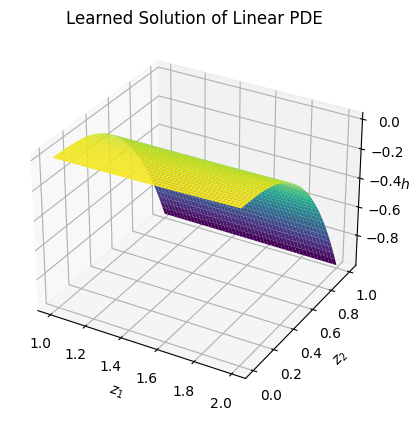

In [ ]:
#Plot learned solution h^*

fig = plt.figure()
ax = plt.axes(projection='3d')
X,Y = jnp.meshgrid(x_grid,y_grid)
ax.plot_surface(X,Y,h_approx,cmap='viridis')
ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2$')
ax.set_zlabel(r'$h$')
ax.zaxis.labelpad=-0.7 # <- change the value here
ax.set_title('Learned Solution of Linear PDE')

In [ ]:
jnp.min(h_approx)

Array(-0.99308033, dtype=float64)

In [ ]:
v2

Array([ 1., -2.], dtype=float64)

In [ ]:
jnp.sqrt(4/5)

Array(0.89442719, dtype=float64, weak_type=True)

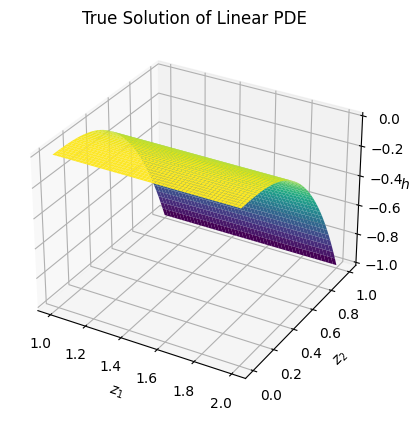

In [ ]:
#True solution h

h_true = (X-2*Y-Y**3)-(v2[0]*X+v2[1]*Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
X,Y = jnp.meshgrid(x_grid,y_grid)
ax.plot_surface(X,Y,h_true,cmap='viridis')
ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2$')
ax.set_zlabel(r'$h$')
ax.set_title('True Solution of Linear PDE')
ax.zaxis.labelpad=-0.7 # <- change the value here


In [ ]:
jnp.min(h_true)

Array(-1., dtype=float64)

In [ ]:
h_true

Array([[-2.22044605e-16, -2.22044605e-16, -2.22044605e-16, ...,
        -4.44089210e-16, -4.44089210e-16, -4.44089210e-16],
       [-8.49985975e-06, -8.49985975e-06, -8.49985975e-06, ...,
        -8.49985975e-06, -8.49985975e-06, -8.49985975e-06],
       [-6.79988780e-05, -6.79988780e-05, -6.79988780e-05, ...,
        -6.79988780e-05, -6.79988780e-05, -6.79988780e-05],
       ...,
       [-8.82480939e-01, -8.82480939e-01, -8.82480939e-01, ...,
        -8.82480939e-01, -8.82480939e-01, -8.82480939e-01],
       [-9.40016490e-01, -9.40016490e-01, -9.40016490e-01, ...,
        -9.40016490e-01, -9.40016490e-01, -9.40016490e-01],
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00]],      dtype=float64)

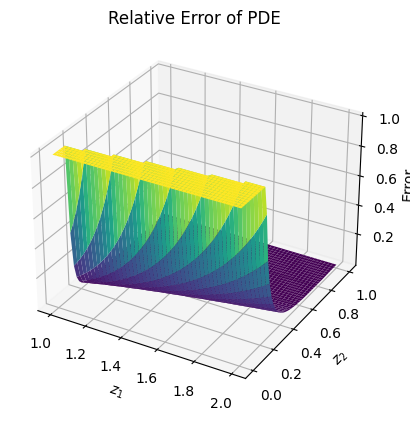

In [ ]:
#L2 relative error

fig = plt.figure()
ax = plt.axes(projection='3d')
X,Y = jnp.meshgrid(x_grid,y_grid)
ax.plot_surface(X,Y,jnp.abs(h_true-h_approx)/(jnp.abs(h_true)+jnp.abs(h_approx)),cmap='viridis')
#plt.title('Solution of Linear PDE')
ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2$')
ax.set_zlabel('Error',rotation=270)
ax.set_title('Relative Error of PDE')
ax.zaxis.labelpad=0.7

In [ ]:
jnp.max(jnp.min((h_true-h_approx)/(jnp.abs(h_true)+jnp.abs(h_approx))))

Array(-1., dtype=float64)

In [ ]:
jnp.abs(h_true-h_approx)/jnp.abs(h_true)

Array([[1.10554673e+13, 1.19317004e+13, 1.28438693e+13, ...,
        4.76148421e+13, 4.89625915e+13, 5.03225574e+13],
       [2.59271420e+02, 2.81062632e+02, 3.03758598e+02, ...,
        2.39647586e+03, 2.46584766e+03, 2.53589871e+03],
       [2.88405536e+01, 3.14274466e+01, 3.41266719e+01, ...,
        2.88262138e+02, 2.96798552e+02, 3.05425978e+02],
       ...,
       [1.48226034e-02, 1.46488200e-02, 1.44735488e-02, ...,
        5.24858163e-03, 5.04455453e-03, 4.84285842e-03],
       [1.56271552e-02, 1.54638495e-02, 1.52989675e-02, ...,
        6.27379601e-03, 6.06334631e-03, 5.85452912e-03],
       [1.64361362e-02, 1.62833753e-02, 1.61290000e-02, ...,
        7.34805292e-03, 7.13338144e-03, 6.91967225e-03]], dtype=float64)